In [ ]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.feature_extraction.text import TfidfVectorizer

def cosine_similarity_matrix(a, b):
    """
    Compute the cosine similarity between two matrices.
    """
    a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = b / np.linalg.norm(b, axis=1, keepdims=True)
    return np.dot(a_norm, b_norm.T)

def weat_effect_size_fast(w, a, b, s_x, s_y):
    """
    Compute the WEAT effect size using vectorized operations.
    """
    w_a = np.mean(cosine_similarity_matrix(w.reshape(1, -1), a))
    w_b = np.mean(cosine_similarity_matrix(w.reshape(1, -1), b))
    s_all = np.vstack((s_x, s_y))
    return (w_a - w_b) / np.std(cosine_similarity_matrix(w.reshape(1, -1), s_all))

def get_embeddings_batch(model, tokenizer, text_list, batch_size=32):
    """
    Get embeddings in batches for efficiency.
    """
     # Set the pad token if it's not already defined
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = model.config.eos_token_id
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
    return np.vstack(embeddings)

# --- Extract Keywords (simplified) ---
def extract_keywords_fast(texts, num_keywords=50):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Extract top keywords for each document
    keywords = []
    for row in tfidf_matrix:
        top_indices = np.argsort(row.toarray()[0])[-num_keywords:]
        keywords.append([feature_names[idx] for idx in top_indices])
    return keywords

# --- Create Word Sets ---
def create_word_sets_fast(keywords_list, top_n=100):
    all_keywords = [word for sublist in keywords_list for word in sublist]
    word_counts = {word: all_keywords.count(word) for word in set(all_keywords)}
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Create word sets based on frequency
    technical_words = [word for word, _ in sorted_words[:top_n]]
    non_technical_words = [word for word, _ in sorted_words[top_n:2 * top_n]]

    return technical_words, non_technical_words

# --- Define target sets (gendered terms) ---
male_terms = ["man", "male", "he", "him"]
female_terms = ["woman", "female", "she", "her"]
#  Ethnicity-related terms
white_terms = ["white", "caucasian", "european"]
black_terms = ["black", "african", "afro-american"]
asian_terms = ["asian", "chinese", "japanese"]
hispanic_terms = ["hispanic", "latino", "spanish"]

# Geography-related terms
us_terms = ["america", "usa", "american"]
europe_terms = ["europe", "european"]
asia_terms = ["asia", "asian"]
africa_terms = ["africa", "african"]


models = {
    "BERT": ("bert-base-uncased", AutoModel),
}

# --- Main Logic ---
# Assuming 'data' is a pandas DataFrame with columns 'Resume' and 'Job Description'
import pandas as pd
data = pd.read_csv("/content/job_applicant_dataset_trial4.csv")

# Extract keywords
resume_keywords = extract_keywords_fast(data['Resume'].tolist())
job_desc_keywords = extract_keywords_fast(data['Job Description'].tolist())

# Create word sets
technical_words, non_technical_words = create_word_sets_fast(resume_keywords + job_desc_keywords)

# Run WEAT for each model
for model_name, (model_path, model_class) in models.items():
    print(f"Running WEAT for {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = model_class.from_pretrained(model_path)

    # Get embeddings
    male_embeddings = get_embeddings_batch(model, tokenizer, male_terms)
    female_embeddings = get_embeddings_batch(model, tokenizer, female_terms)
    technical_embeddings = get_embeddings_batch(model, tokenizer, technical_words)
    non_technical_embeddings = get_embeddings_batch(model, tokenizer, non_technical_words)
    white_embeddings = get_embeddings_batch(model, tokenizer, white_terms)
    black_embeddings = get_embeddings_batch(model, tokenizer, black_terms)
    asian_embeddings = get_embeddings_batch(model, tokenizer, asian_terms)
    hispanic_embeddings = get_embeddings_batch(model, tokenizer, hispanic_terms)
    us_embeddings = get_embeddings_batch(model, tokenizer, us_terms)
    europe_embeddings = get_embeddings_batch(model, tokenizer, europe_terms)
    asia_embeddings = get_embeddings_batch(model, tokenizer, asia_terms)
    africa_embeddings = get_embeddings_batch(model, tokenizer, africa_terms)

    # Calculate average embeddings
    avg_male_embedding = np.mean(male_embeddings, axis=0)
    avg_female_embedding = np.mean(female_embeddings, axis=0)
    avg_technical_embedding = np.mean(technical_embeddings, axis=0)
    avg_non_technical_embedding = np.mean(non_technical_embeddings, axis=0)
    avg_white_embedding = np.mean(white_embeddings, axis=0)
    avg_black_embedding = np.mean(black_embeddings, axis=0)
    avg_asian_embedding = np.mean(asian_embeddings, axis=0)
    avg_hispanic_embedding = np.mean(hispanic_embeddings, axis=0)
    avg_us_embedding = np.mean(us_embeddings, axis=0)
    avg_europe_embedding = np.mean(europe_embeddings, axis=0)
    avg_asia_embedding = np.mean(asia_embeddings, axis=0)
    avg_africa_embedding = np.mean(africa_embeddings, axis=0)


    # Calculate WEAT effect sizes
    technical_male_effect_size = weat_effect_size_fast(avg_technical_embedding, male_embeddings, female_embeddings,
                                                     technical_embeddings, non_technical_embeddings)
    technical_female_effect_size = weat_effect_size_fast(avg_technical_embedding, female_embeddings, male_embeddings,technical_embeddings, non_technical_embeddings)

    non_technical_male_effect_size = weat_effect_size_fast(avg_non_technical_embedding, male_embeddings, female_embeddings,
                                                         technical_embeddings, non_technical_embeddings)
    non_technical_female_effect_size = weat_effect_size_fast(avg_non_technical_embedding, female_embeddings,
                                                              male_embeddings,technical_embeddings, non_technical_embeddings)
    technical_white_effect_size = weat_effect_size_fast(avg_technical_embedding, white_embeddings, black_embeddings,
                                                    technical_embeddings, non_technical_embeddings)
    technical_black_effect_size = weat_effect_size_fast(avg_technical_embedding, black_embeddings, white_embeddings,
                                                    technical_embeddings, non_technical_embeddings)
    technical_asian_effect_size = weat_effect_size_fast(avg_technical_embedding, asian_embeddings, hispanic_embeddings,
                                                    technical_embeddings, non_technical_embeddings)
    technical_hispanic_effect_size = weat_effect_size_fast(avg_technical_embedding, hispanic_embeddings, asian_embeddings,
                                                       technical_embeddings, non_technical_embeddings)
    technical_us_effect_size = weat_effect_size_fast(avg_technical_embedding, us_embeddings, europe_embeddings,
                                                 technical_embeddings, non_technical_embeddings)
    technical_europe_effect_size = weat_effect_size_fast(avg_technical_embedding, europe_embeddings, asia_embeddings,
                                                     technical_embeddings, non_technical_embeddings)
    technical_asia_effect_size = weat_effect_size_fast(avg_technical_embedding, asia_embeddings, africa_embeddings,
                                                   technical_embeddings, non_technical_embeddings)
    technical_africa_effect_size = weat_effect_size_fast(avg_technical_embedding, africa_embeddings, us_embeddings,
                                                     technical_embeddings, non_technical_embeddings)
    weat_us_europe = weat_effect_size_fast(avg_technical_embedding, us_embeddings, europe_embeddings,
                                       technical_embeddings, non_technical_embeddings)

    weat_us_asia = weat_effect_size_fast(avg_technical_embedding, us_embeddings, asia_embeddings,
                                     technical_embeddings, non_technical_embeddings)

    weat_europe_asia = weat_effect_size_fast(avg_technical_embedding, europe_embeddings, asia_embeddings,
                                         technical_embeddings, non_technical_embeddings)
    weat_technical_white_black = weat_effect_size_fast(avg_technical_embedding,  white_embeddings, black_embeddings, technical_embeddings,
    non_technical_embeddings )
    # Print results
    print(f"WEAT Effect Size (Technical vs. Male): {technical_male_effect_size}")
    print(f"WEAT Effect Size (Technical vs. Female): {technical_female_effect_size}")
    print(f"WEAT Effect Size (Non-Technical vs. Male): {non_technical_male_effect_size}")
    print(f"WEAT Effect Size (Non-Technical vs. Female): {non_technical_female_effect_size}")
    print(f"WEAT Effect Size (Technical vs. White): {technical_white_effect_size}")
    print(f"WEAT Effect Size (Technical vs. Black): {technical_black_effect_size}")
    print(f"WEAT Effect Size (Technical vs. Asian): {technical_asian_effect_size}")
    print(f"WEAT Effect Size (Technical vs. Hispanic): {technical_hispanic_effect_size}")
    print(f"WEAT Effect Size (Technical vs. US): {technical_us_effect_size}")
    print(f"WEAT Effect Size (Technical vs. Europe): {technical_europe_effect_size}")
    print(f"WEAT Effect Size (Technical vs. Asia): {technical_asia_effect_size}")
    print(f"WEAT Effect Size (Technical vs. Africa): {technical_africa_effect_size}")
    print(f"WEAT Effect Size (Technical vs. US vs. Europe): {weat_us_europe}")
    print(f"WEAT Effect Size (Technical vs. US vs. Asia): {weat_us_asia}")
    print(f"WEAT Effect Size (Technical vs. Europe vs. Asia): {weat_europe_asia}")
    print(f"WEAT Effect Size (Technical vs White vs Black): {weat_technical_white_black}")

Running WEAT for BERT


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


WEAT Effect Size (Technical vs. Male): -0.23972250521183014
WEAT Effect Size (Technical vs. Female): 0.23972250521183014
WEAT Effect Size (Non-Technical vs. Male): -0.2512228488922119
WEAT Effect Size (Non-Technical vs. Female): 0.2512228488922119


In [ ]:
gender_bias_results = {
    "Technical vs Male": technical_male_effect_size,
    "Technical vs Female": technical_female_effect_size,
    "Non-Technical vs Male": non_technical_male_effect_size,
    "Non-Technical vs Female": non_technical_female_effect_size,
}

# GEOGRAPHICAL BIAS
geo_bias_results = {
    "Technical vs US": technical_us_effect_size,
    "Technical vs Europe": technical_europe_effect_size,
    "Technical vs Asia": technical_asia_effect_size,
    "Technical vs Africa": technical_africa_effect_size,
    "US vs Europe": weat_us_europe,
    "US vs Asia": weat_us_asia,
    "Europe vs Asia": weat_europe_asia,
}

# ETHNICITY & RACIAL BIAS
ethnicity_bias_results = {
    "Technical vs White": technical_white_effect_size,
    "Technical vs Black": technical_black_effect_size,
    "Technical vs Asian": technical_asian_effect_size,
    "Technical vs Hispanic": technical_hispanic_effect_size,
    "Technical vs White vs Black": weat_technical_white_black,
}

import matplotlib.pyplot as plt
import seaborn as sns

def plot_weat_results(results, title):
    """Plots a horizontal bar chart for a given WEAT results dictionary."""
    results = dict(sorted(results.items(), key=lambda x: x[1]))  # Sort by bias score
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(results.values()), y=list(results.keys()), palette="coolwarm", orient="h")

    # Add reference line at 0
    plt.axvline(0, color="black", linestyle="--")
    plt.xlabel("WEAT Effect Size (Bias Score)")
    plt.ylabel("Comparisons")
    plt.title(title)
    plt.show()
    # Plot Gender Bias
plot_weat_results(gender_bias_results, "WEAT Effect Size: Gender Bias Analysis")

# Plot Geographical Bias
plot_weat_results(geo_bias_results, "WEAT Effect Size: Geographical Bias Analysis")

# Plot Ethnicity & Racial Bias
plot_weat_results(ethnicity_bias_results, "WEAT Effect Size: Ethnicity & Racial Bias Analysis")

In [ ]:
w = np.mean(technical_embeddings, axis=0)
w = w / np.linalg.norm(w)
# Cosine similarities with w
cosine_sim_technical = cosine_similarity_matrix(w.reshape(1, -1), technical_embeddings)
cosine_sim_non_technical = cosine_similarity_matrix(w.reshape(1, -1), non_technical_embeddings)

# Display statistics
print("Average Cosine Similarity (Technical):", np.mean(cosine_sim_technical))
print("Average Cosine Similarity (Non-Technical):", np.mean(cosine_sim_non_technical))

Average Cosine Similarity (Technical): 0.8584676
Average Cosine Similarity (Non-Technical): 0.8680557


In [ ]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.feature_extraction.text import TfidfVectorizer

def cosine_similarity_matrix(a, b):
    """
    Compute the cosine similarity between two matrices.
    """
    a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = b / np.linalg.norm(b, axis=1, keepdims=True)
    return np.dot(a_norm, b_norm.T)

def weat_effect_size_fast(w, a, b, s_x, s_y):
    """
    Compute the WEAT effect size using vectorized operations.
    """
    w_a = np.mean(cosine_similarity_matrix(w.reshape(1, -1), a))
    w_b = np.mean(cosine_similarity_matrix(w.reshape(1, -1), b))
    s_all = np.vstack((s_x, s_y))
    return (w_a - w_b) / np.std(cosine_similarity_matrix(w.reshape(1, -1), s_all))

def get_embeddings_batch(model, tokenizer, text_list, batch_size=32):
    """
    Get embeddings in batches for efficiency.
    """
     # Set the pad token if it's not already defined
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = model.config.eos_token_id
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
    return np.vstack(embeddings)

# --- Extract Keywords (simplified) ---
def extract_keywords_fast(texts, num_keywords=50):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()

    # Extract top keywords for each document
    keywords = []
    for row in tfidf_matrix:
        top_indices = np.argsort(row.toarray()[0])[-num_keywords:]
        keywords.append([feature_names[idx] for idx in top_indices])
    return keywords

# --- Create Word Sets ---
def create_word_sets_fast(keywords_list, top_n=100):
    all_keywords = [word for sublist in keywords_list for word in sublist]
    word_counts = {word: all_keywords.count(word) for word in set(all_keywords)}
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Create word sets based on frequency
    technical_words = [word for word, _ in sorted_words[:top_n]]
    non_technical_words = [word for word, _ in sorted_words[top_n:2 * top_n]]

    return technical_words, non_technical_words

# --- Main Logic ---
# Load models
models = {
    "BERT": ("bert-base-uncased", AutoModel),
}

# Assuming 'data' is a pandas DataFrame with columns 'Resume' and 'Job Description'
import pandas as pd
data = pd.read_csv("/content/job_applicant_dataset_trial4.csv")

# Extract keywords
resume_keywords = extract_keywords_fast(data['Resume'].tolist())
job_desc_keywords = extract_keywords_fast(data['Job Description'].tolist())

# Create word sets
technical_words, non_technical_words = create_word_sets_fast(resume_keywords + job_desc_keywords)
print("Technical Words:", technical_words)
print("Non-Technical Words:", non_technical_words)

# Optionally, save to a file for inspection
with open("technical_words.txt", "w") as f:
    f.write("\n".join(technical_words))

with open("non_technical_words.txt", "w") as f:
    f.write("\n".join(non_technical_words))

# Run WEAT for each model
for model_name, (model_path, model_class) in models.items():
    print(f"Running WEAT for {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = model_class.from_pretrained(model_path)
     # Set the pad token if it's not already defined
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = model.config.eos_token_id

    # Get embeddings
    technical_embeddings = get_embeddings_batch(model, tokenizer, technical_words)
    non_technical_embeddings = get_embeddings_batch(model, tokenizer, non_technical_words)

    # Calculate WEAT metrics
    w = np.mean(technical_embeddings, axis=0) # Example: Using the first technical embedding as 'w'
    effect_size = weat_effect_size_fast(w, technical_embeddings, non_technical_embeddings,
                                        technical_embeddings, non_technical_embeddings)

    print(f"WEAT Effect Size: {effect_size}")


Technical Words: ['design', 'data', 'environments', 'results', 'level', 'delivering', 'deep', 'field', 'experience', 'dynamic', 'certifications', 'proficient', 'adapting', 'holds', 'skilled', 'degree', 'dba', 'development', 'databases', 'database', 'dds', 'cyber', 'deals', 'designer', 'customer', 'developer', 'devices', 'dental', 'deployment', 'desk', 'desktop', 'device', 'cvt', 'dentistry', 'cup', 'senior', 'devops', 'role', 'culinary', 'diagnosis', 'work', 'certified', 'skills', 'management', 'strong', 'cua', 'ensure', 'understanding', 'ensuring', 'requires', 'differentiated', 'problem', 'ability', 'solving', 'research', 'phd', 'masters', 'bachelors', 'digital', 'systems', 'mid', 'responsible', 'communication', 'zoning', 'csw', 'engineer', 'develop', 'collaborate', 'certification', 'corporate', 'create', 'closely', 'essential', 'engineering', 'demands', 'improve', 'high', 'solutions', 'teams', 'engineers', 'content', 'care', 'business', 'involves', 'project', 'company', 'expertise', 

In [ ]:
# Define target sets (gendered terms)
male_terms = ["man", "male", "he", "him", "father", "son", "brother"]
female_terms = ["woman", "female", "she", "her", "mother", "daughter", "sister"]

# Use technical and non-technical word sets as attribute sets
attribute_technical = technical_words
attribute_non_technical = non_technical_words

# Load the model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Get embeddings for all sets
male_embeddings = get_embeddings_batch(model, tokenizer, male_terms)
female_embeddings = get_embeddings_batch(model, tokenizer, female_terms)
technical_embeddings = get_embeddings_batch(model, tokenizer, attribute_technical)
non_technical_embeddings = get_embeddings_batch(model, tokenizer, attribute_non_technical)

# Calculate WEAT effect sizes
male_effect_size = weat_effect_size_fast(np.mean(male_embeddings, axis=0),
                                         technical_embeddings, non_technical_embeddings,
                                         technical_embeddings, non_technical_embeddings)
female_effect_size = weat_effect_size_fast(np.mean(female_embeddings, axis=0),
                                           technical_embeddings, non_technical_embeddings,
                                           technical_embeddings, non_technical_embeddings)

# Print results
print(f"WEAT Effect Size for Male Terms: {male_effect_size}")
print(f"WEAT Effect Size for Female Terms: {female_effect_size}")


WEAT Effect Size for Male Terms: -0.43237289786338806
WEAT Effect Size for Female Terms: -0.41620150208473206


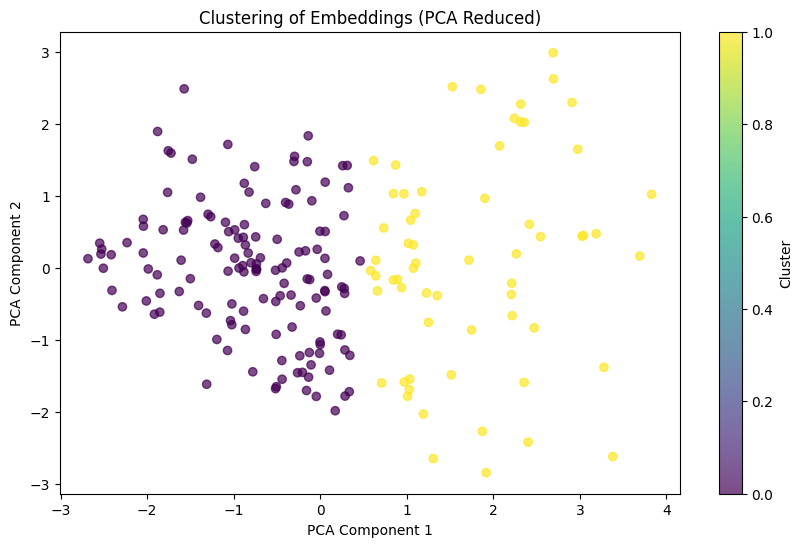

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Combine embeddings (ensure `technical_embeddings` and `non_technical_embeddings` are computed)
all_embeddings = np.vstack((technical_embeddings, non_technical_embeddings))
labels = ['Technical'] * len(technical_embeddings) + ['Non-Technical'] * len(non_technical_embeddings)

# Step 2: Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Step 4: Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap="viridis", alpha=0.7)
plt.title("Clustering of Embeddings (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()
